In [1]:
# Install required libraries
!pip install transformers datasets evaluate shap lime matplotlib seaborn --quiet
!pip install -U transformers datasets evaluate accelerate
!pip install -q bitsandbytes  # optional if you want faster training on Colab GPUs

# Optional: Login to Hugging Face if using private models or datasets
# from huggingface_hub import notebook_login
# notebook_login()
from huggingface_hub import login
import os

# Login using the token stored in Colab secrets
login(token=os.getenv("HF_TOKEN"))



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.1 MB/s eta 0:00:00


# **Initializing the session**


In [2]:
# Mounting the Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

# Creating folders for saving outputs and checkpoints
import os
PROJECT_DIR = "/content/drive/MyDrive/AfroXLMR_Experiment"
os.makedirs(f"{PROJECT_DIR}/outputs", exist_ok=True)
os.makedirs(f"{PROJECT_DIR}/logs", exist_ok=True)

%cd /content/drive/MyDrive

import os

# PROJECT_DIR = '/content/drive/MyDrive/afrisent-semeval-2023'
PROJECT_GITHUB_URL = 'https://github.com/afrisenti-semeval/afrisent-semeval-2023.git'

# if not os.path.isdir(PROJECT_DIR):
#   !git clone {PROJECT_GITHUB_URL}
# else:
#   %cd {PROJECT_DIR}
#   !git pull {PROJECT_GITHUB_URL}


# Install libraries
!pip install -q transformers datasets evaluate accelerate huggingface_hub bitsandbytes
!pip install -q shap lime matplotlib seaborn scikit-learn

# Import libraries
import torch
import random
import numpy as np
import pandas as pd
from datasets import load_dataset

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Environment initialized (CPU mode).")


Mounted at /content/drive
/content/drive/MyDrive
Environment initialized (CPU mode).


# **Loading data and preprocessing**

In [3]:
# Load datasets (AfriSenti + isiXhosa)
# afrisenti = load_dataset("Davlan/afrisent-semeval-2023", "swahili")
# xhosa_ds = load_dataset("cuit/xhosa-sentiment")
# Load the AfriSenti dataset (via GitHub or local)
# If there is no direct HF dataset for each language, you may need to load via GitHub files.

import pandas as pd

def load_afrisenti_language(lang_code, lang_name):
    """
    Loads a specific language's training data from the AfriSenti GitHub repo.
    """
    base_url = "https://raw.githubusercontent.com/afrisenti-semeval/afrisent-semeval-2023/main/SubtaskA/train"
    url = f"{base_url}/{lang_code}_train.tsv"

    try:
        df = pd.read_csv(url, sep="\t", header=0, quoting=3, encoding='utf-8')
        # Some files use inconsistent column names, so we normalize
        df.columns = [c.lower() for c in df.columns]
        if "label" not in df.columns:
            df.rename(columns={"sentiment": "label"}, inplace=True)
        df["language"] = lang_name
        print(f"Loaded {lang_name} ({len(df)} rows)")
        return df
    except Exception as e:
        print(f"Error loading {lang_name}: {e}")
        return pd.DataFrame()

# Load selected source languages
langs = {
    "sw": "swahili",
     "ts": "xitsonga"
}

frames = [load_afrisenti_language(code, name) for code, name in langs.items()]
combined_df = pd.concat(frames, ignore_index=True)

# Clean and sanity check
combined_df = combined_df.dropna(subset=["tweet"])
afrisenti_df  = combined_df.drop_duplicates(subset=["tweet"])
print(f"\n Combined dataset shape: {afrisenti_df .shape}")
print(afrisenti_df.head())




Loaded swahili (1810 rows)
Loaded xitsonga (804 rows)

 Combined dataset shape: (2606, 4)
               id                                              tweet  \
0  sw_train_00001  Kwani tanesco wanakataga umeme makusudinadhani...   
1  sw_train_00002  cjawahi kuona content yoyote zaidi ya kuwa ana...   
2  sw_train_00003  Bomu lililokuwa limetegwa ndani ya gari likiwa...   
3  sw_train_00004  Kuna video inasambaa mitandaoni jamaa amemfuma...   
4  sw_train_00005  Viwavijeshi wanapita katika hatua kuu 6 za uku...   

      label language  
0  negative  swahili  
1  negative  swahili  
2  negative  swahili  
3  negative  swahili  
4  negative  swahili  


In [4]:
afrisenti_df.tail()

id                                              tweet  \
2609  ts_train_00800                      Teka Famba Ya Man .. Te amo 😻   
2610  ts_train_00801  Va galhi tiMbatsana kaMarracuene. https://t.co...   
2611  ts_train_00802                           @user Wena wa tsoga yong   
2612  ts_train_00803       @user Ya va dudamel deja la vino tinto vermo   
2613  ts_train_00804  A Xikwembo A Xi Ku Katekisse 🙏🙏🙏 https://t.co/...   

         label  language  
2609  positive  xitsonga  
2610  positive  xitsonga  
2611  positive  xitsonga  
2612  positive  xitsonga  
2613  positive  xitsonga

In [5]:
# Load Xhosa dataset dataset

In [6]:
xhosa_df = pd.read_parquet("hf://datasets/michsethowusu/xhosa-sentiments-corpus/data/train-00000-of-00001-4387e2c7c77f2f2f.parquet")

In [7]:
xhosa_df.head()

Xhosa sentiment  \
0             Usezandleni zikaThixo, endimnqulayo. "  Positive   
1  Uthi: "Ndiyakuthanda ukuxelela abanye ngenyaniso.  Positive   
2  Siya kumenzela ntoni na udade wethu mhla kuya ...  Negative   
3  Abanye kusenokwenzeka abazange batsho la mazwi...  Positive   
4                        ngenyaniso akufundise yona?  Positive   

   __index_level_0__  
0                  0  
1                  1  
2                  2  
3                  3  
4                  4

In [8]:
# Normalize column names
xhosa_df.columns = [c.lower() for c in xhosa_df.columns]
if "text" not in xhosa_df.columns and "xhosa" in xhosa_df.columns:
    xhosa_df.rename(columns={"xhosa": "text"}, inplace=True)
if "label" not in xhosa_df.columns:
    xhosa_df.rename(columns={"sentiment": "label"}, inplace=True)

xhosa_df["language"] = "xhosa"
print(f"Loaded isiXhosa dataset: {xhosa_df.shape}")

# Harmonize columns with AfriSenti
afrisenti_df.rename(columns={"tweet": "text"}, inplace=True)
combined_df = pd.concat([afrisenti_df, xhosa_df], ignore_index=True, sort=False)
print(f"\n Combined multilingual dataset: {combined_df.shape}")

Loaded isiXhosa dataset: (1499997, 4)

 Combined multilingual dataset: (1502603, 5)


/tmp/ipython-input-1675634368.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afrisenti_df.rename(columns={"tweet": "text"}, inplace=True)


In [9]:
afrisenti_df.head()

id                                               text  \
0  sw_train_00001  Kwani tanesco wanakataga umeme makusudinadhani...   
1  sw_train_00002  cjawahi kuona content yoyote zaidi ya kuwa ana...   
2  sw_train_00003  Bomu lililokuwa limetegwa ndani ya gari likiwa...   
3  sw_train_00004  Kuna video inasambaa mitandaoni jamaa amemfuma...   
4  sw_train_00005  Viwavijeshi wanapita katika hatua kuu 6 za uku...   

      label language  
0  negative  swahili  
1  negative  swahili  
2  negative  swahili  
3  negative  swahili  
4  negative  swahili

In [10]:
xhosa_df.head()

text     label  \
0             Usezandleni zikaThixo, endimnqulayo. "  Positive   
1  Uthi: "Ndiyakuthanda ukuxelela abanye ngenyaniso.  Positive   
2  Siya kumenzela ntoni na udade wethu mhla kuya ...  Negative   
3  Abanye kusenokwenzeka abazange batsho la mazwi...  Positive   
4                        ngenyaniso akufundise yona?  Positive   

   __index_level_0__ language  
0                  0    xhosa  
1                  1    xhosa  
2                  2    xhosa  
3                  3    xhosa  
4                  4    xhosa

In [11]:

# # Optional isiZulu
# try:
#     zulu_ds = load_dataset("Davlan/afrisent-semeval-2023", "zulu")
# except:
#     zulu_ds = None
#     print(" isiZulu dataset not found.")

# Basic cleaning function
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# Apply cleaning
# def preprocess_dataset(ds, text_col="text", label_col="label"):
#     ds = ds.map(lambda e: {"text": clean_text(e[text_col])})
#     ds = ds.rename_column(label_col, "labels")
#     ds = ds.remove_columns([c for c in ds.column_names if c not in ["text", "labels"]])
#     return ds

# afrisenti_clean = preprocess_dataset(afrisenti_df)
# xhosa_clean = preprocess_dataset(xhosa_df)
afrisenti_df["clean_text"] = afrisenti_df["text"].apply(clean_text)
afrisenti_clean = afrisenti_df.drop_duplicates(subset=["clean_text"])

xhosa_df["clean_text"] = xhosa_df["text"].apply(clean_text)
xhosa_clean = xhosa_df.drop_duplicates(subset=["clean_text"])
print(" Datasets cleaned and ready for tokenization.")


 Datasets cleaned and ready for tokenization.


In [12]:
# xhosa_clean.drop(columns=["__index_level_0__"] , inplace=True)
xhosa_clean.rename(columns={"__index_level_0__": "id"}, inplace=True)

/tmp/ipython-input-2595633771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xhosa_clean.rename(columns={"__index_level_0__": "id"}, inplace=True)


In [13]:
#Convert the pandas dataframes to huggingface dataframes
# from datasets import Dataset

# afrisenti_dataset = Dataset.from_pandas(afrisenti_clean)
# xhosa_dataset = Dataset.from_pandas(xhosa_clean)


In [14]:
# from transformers import AutoTokenizer

# MODEL_NAME = "Davlan/afro-xlmr-base"
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# def tokenize_fn(batch):
#     return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

# afrisenti_tok = afrisenti_dataset.map(tokenize_fn, batched=True)
# xhosa_tok = xhosa_dataset.map(tokenize_fn, batched=True)

# print(" Tokenization complete. You can now inspect or sample the data safely.")

# # Example: check a random sample
# afrisenti_tok.shuffle(seed=42).select(range(3))


#**Data exploration**

In [15]:
# 1. Imports
# =========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Optional: Pretty display for pandas
pd.set_option('display.max_colwidth', 100)
sns.set(style="whitegrid", font_scale=1.1)


In [16]:
xhosa_clean_sample = xhosa_clean.sample(n=2000, random_state=42)

In [17]:
xhosa_clean.label.value_counts(normalize=True)

label
Positive    0.561212
Negative    0.438788
Name: proportion, dtype: float64

In [18]:
xhosa_clean_sample.label.value_counts(normalize=True)

label
Positive    0.555
Negative    0.445
Name: proportion, dtype: float64

In [59]:
xhosa_clean_sample[xhosa_clean_sample.label=='Negative']

text  \
768073                                  Cofa apha ukuze uthumele impendulo kaDaniela!   
537218                                               okay..here goes nothing...thanks   
1261627                                    Joyous Celebration - Wena Wedwa Qha (Live)   
1437259                                AmaZulu afumene amanqaku amathathu apheleleyo.   
648233   Nantoni na eyenziwa ngumntwana kwintanga yesibini, kufuneka uhlale ekhusela.   
...                                                                               ...   
573952        Oko kukuthi, umsebenzi wayo oyintloko kukuba unike umfanekiso ofunwayo.   
15537                      Okanye "hambani," njengoko sifanele sihambe emva kobusuku.   
149454        Kule minyaka, iimveliso zethu bezithengisa kakuhle eYurophu naseMelika.   
410656                               Mhlawumbi unomfazi onoyovuyo omele uvelane naye.   
851729      HuaTan uye intyatyambo imbiza ezintle ukuhlangabezana nemfuno yabathengi.   

            label       id language  \
768073   Negative   768075    xhosa   
537218   Negative   537218    xhosa   
1261627  Negative  1261630    xhosa   
1437259  Negative  1437262    xhosa   
648233   Negative   648235    xhosa   
...           ...      ...      ...   
573952   Negative   573953    xhosa   
15537    Negative    15537    xhosa   
149454   Negative   149454    xhosa   
410656   Negative   410656    xhosa   
851729   Negative   851731    xhosa   

                                                                         clean_text  
768073                                 Cofa apha ukuze uthumele impendulo kaDaniela  
537218                                                  okayhere goes nothingthanks  
1261627                                     Joyous Celebration  Wena Wedwa Qha Live  
1437259                               AmaZulu afumene amanqaku amathathu apheleleyo  
648233   Nantoni na eyenziwa ngumntwana kwintanga yesibini kufuneka uhlale ekhusela  
...                                                                             ...  
573952        Oko kukuthi umsebenzi wayo oyintloko kukuba unike umfanekiso ofunwayo  
15537                        Okanye hambani njengoko sifanele sihambe emva kobusuku  
149454        Kule minyaka iimveliso zethu bezithengisa kakuhle eYurophu naseMelika  
410656                              Mhlawumbi unomfazi onoyovuyo omele uvelane naye  
851729     HuaTan uye intyatyambo imbiza ezintle ukuhlangabezana nemfuno yabathengi  

[890 rows x 5 columns]

In [19]:
# 2. Load or combine datasets
# =========================================
# If you already have them in memory:
combined_df = pd.concat([afrisenti_clean, xhosa_clean_sample], ignore_index=True)


print(f" Combined multilingual dataset: {combined_df.shape}")
print(combined_df.head(3))

 Combined multilingual dataset: (4605, 5)
               id  \
0  sw_train_00001   
1  sw_train_00002   
2  sw_train_00003   

                                                                                                  text  \
0  Kwani tanesco wanakataga umeme makusudinadhani kuna changamoto behind zinatakiwa zitatuliwe na s...   
1  cjawahi kuona content yoyote zaidi ya kuwa analalamika cjawahi kuona akitafuta solution ya tatti...   
2  Bomu lililokuwa limetegwa ndani ya gari likiwalenga wajenzi kutoka Uturuki limelipuka katika ene...   

      label language  \
0  negative  swahili   
1  negative  swahili   
2  negative  swahili   

                                                                                            clean_text  
0  Kwani tanesco wanakataga umeme makusudinadhani kuna changamoto behind zinatakiwa zitatuliwe na s...  
1  cjawahi kuona content yoyote zaidi ya kuwa analalamika cjawahi kuona akitafuta solution ya tatti...  
2  Bomu lililokuwa limetegwa ndani y

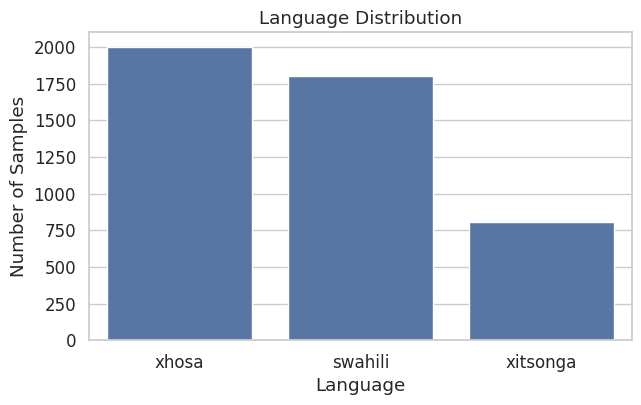

language
xhosa       2000
swahili     1802
xitsonga     803
Name: count, dtype: int64

In [20]:
#  3. Language distribution
# =========================================
lang_counts = combined_df["language"].value_counts()
plt.figure(figsize=(7,4))
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title("Language Distribution")
plt.xlabel("Language")
plt.ylabel("Number of Samples")
plt.show()

lang_counts

/tmp/ipython-input-4043664578.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="crest")


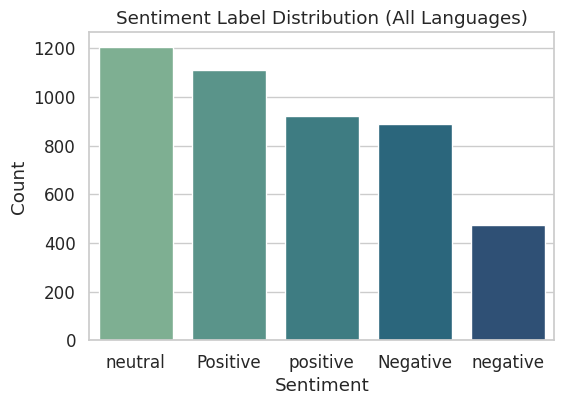

label
neutral     1206
Positive    1110
positive     924
Negative     890
negative     475
Name: count, dtype: int64

In [21]:
# 4. Sentiment label distribution (overall)
# =========================================
label_counts = combined_df["label"].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="crest")
plt.title("Sentiment Label Distribution (All Languages)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

label_counts

In [22]:
combined_df['label'] = combined_df['label'].apply(lambda x: x.lower() if isinstance(x, str) else x)

/tmp/ipython-input-187122703.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="crest")


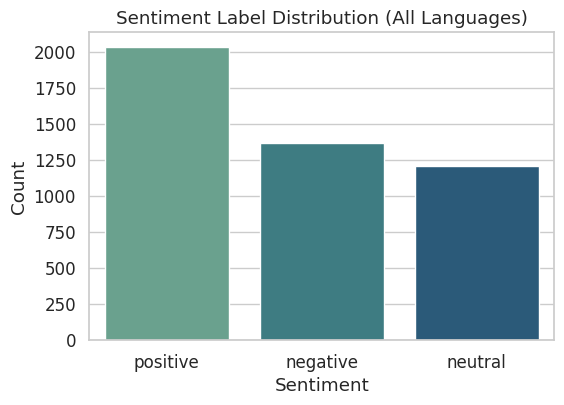

label
positive    2034
negative    1365
neutral     1206
Name: count, dtype: int64

In [23]:
label_counts = combined_df["label"].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="crest")
plt.title("Sentiment Label Distribution (All Languages)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

label_counts

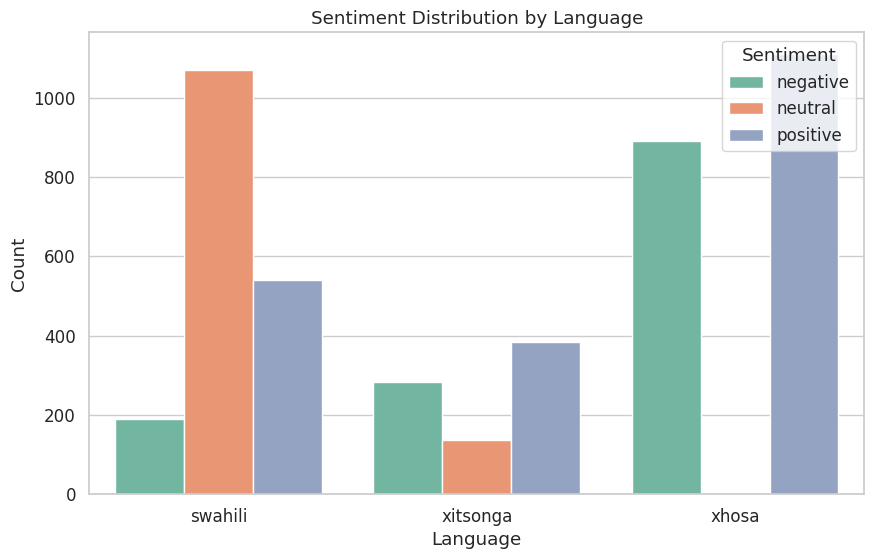

In [24]:
# 5. Sentiment per language
# =========================================
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df, x="language", hue="label", palette="Set2")
plt.title("Sentiment Distribution by Language")
plt.xlabel("Language")
plt.ylabel("Count")
plt.legend(title="Sentiment", loc="upper right")
plt.show()

From the EDA I noted that the xhosa dataset has not neutral labels in comparison to the xitsonga and swahili data. The difference in label distribution is very important to think about when doing cross-lingual sentiment transfer learning. This issue introduces a label mismatch between the training and evaluation datasets.
Since this study focuses on transfer learning and cross-lingual generalization I will Use binary labels for now, to harmonize everything to positive/negative. Will make changes at the end of the EDA section and re-tokenize.

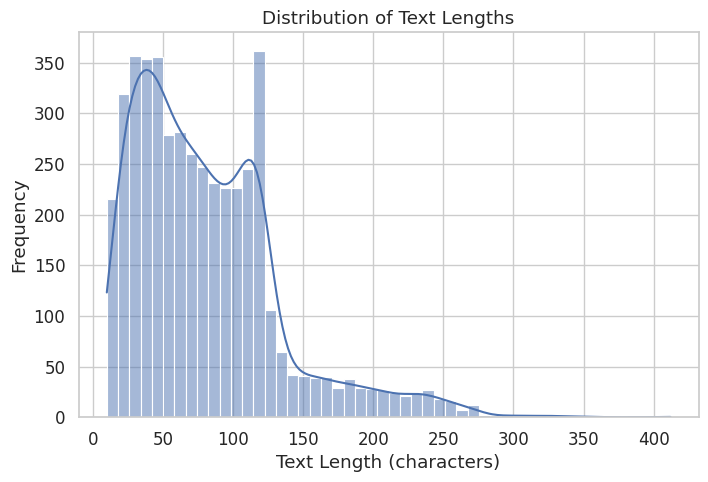

Average text length by language:
language
swahili     108.2
xhosa        65.7
xitsonga     57.1
Name: text_len, dtype: float64


In [25]:
#  6. Text length analysis
# =========================================
combined_df["text_len"] = combined_df["text"].astype(str).apply(len)

plt.figure(figsize=(8,5))
sns.histplot(combined_df["text_len"], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

print("Average text length by language:")
print(combined_df.groupby("language")["text_len"].mean().round(1))

In [26]:
combined_df[combined_df['language'] == 'swahili']

id  \
0     sw_train_00001   
1     sw_train_00002   
2     sw_train_00003   
3     sw_train_00004   
4     sw_train_00005   
...              ...   
1797  sw_train_01806   
1798  sw_train_01807   
1799  sw_train_01808   
1800  sw_train_01809   
1801  sw_train_01810   

                                                                                                     text  \
0     Kwani tanesco wanakataga umeme makusudinadhani kuna changamoto behind zinatakiwa zitatuliwe na s...   
1     cjawahi kuona content yoyote zaidi ya kuwa analalamika cjawahi kuona akitafuta solution ya tatti...   
2     Bomu lililokuwa limetegwa ndani ya gari likiwalenga wajenzi kutoka Uturuki limelipuka katika ene...   
3     Kuna video inasambaa mitandaoni jamaa amemfumania mkewe akiwa na jamaa mwingine huku akimlalamik...   
4     Viwavijeshi wanapita katika hatua kuu 6 za ukuaji katika hatua yake ya larvae mayai 10001500 hut...   
...                                                                                                   ...   
1797                                                                       Usicheke watu wanapitia mazito   
1798                                                Bora Kuogopwa maana wakikupenda ipo siku Watakuchukia   
1799                           Waziri Mwijage akizindua mashine ya kusaga nafaka iliyotengenezwa kijijini   
1800                                                                     Ukiweka kinyongo ni wewe utaumia   
1801                   Asanteni Asanteni kwa kuungana na mimi sasa tuendelee kuelimika kutoka kwa wengine   

         label language  \
0     negative  swahili   
1     negative  swahili   
2     negative  swahili   
3     negative  swahili   
4     negative  swahili   
...        ...      ...   
1797  positive  swahili   
1798  positive  swahili   
1799  positive  swahili   
1800  positive  swahili   
1801  positive  swahili   

                                                                                               clean_text  \
0     Kwani tanesco wanakataga umeme makusudinadhani kuna changamoto behind zinatakiwa zitatuliwe na s...   
1     cjawahi kuona content yoyote zaidi ya kuwa analalamika cjawahi kuona akitafuta solution ya tatti...   
2     Bomu lililokuwa limetegwa ndani ya gari likiwalenga wajenzi kutoka Uturuki limelipuka katika ene...   
3     Kuna video inasambaa mitandaoni jamaa amemfumania mkewe akiwa na jamaa mwingine huku akimlalamik...   
4     Viwavijeshi wanapita katika hatua kuu 6 za ukuaji katika hatua yake ya larvae mayai 10001500 hut...   
...                                                                                                   ...   
1797                                                                       Usicheke watu wanapitia mazito   
1798                                                Bora Kuogopwa maana wakikupenda ipo siku Watakuchukia   
1799                           Waziri Mwijage akizindua mashine ya kusaga nafaka iliyotengenezwa kijijini   
1800                                                                     Ukiweka kinyongo ni wewe utaumia   
1801                   Asanteni Asanteni kwa kuungana na mimi sasa tuendelee kuelimika kutoka kwa wengine   

      text_len  
0          112  
1          163  
2          195  
3          118  
4          251  
...        ...  
1797        30  
1798        53  
1799        74  
1800        32  
1801        82  

[1802 rows x 6 columns]

In [27]:
# 7. Missing and duplicate checks
# =========================================
print("Missing values:\n", combined_df.isnull().sum())
print("\nDuplicates:", combined_df.duplicated(subset="text").sum())

Missing values:
 id            0
text          0
label         0
language      0
clean_text    0
text_len      0
dtype: int64

Duplicates: 0


In [28]:
# 8. Most frequent words (optional)
# =========================================
from collections import Counter
import re

def word_freq(df, lang, n=15):
    texts = df[df.language == lang]["text"].astype(str)
    words = " ".join(texts).lower()
    words = re.findall(r"\b[a-zA-Z']+\b", words)
    return Counter(words).most_common(n)

for lang in combined_df["language"].unique():
    print(f"\nTop words for {lang.title()}:")
    print(word_freq(combined_df, lang, n=10))


Top words for Swahili:
[('ya', 1247), ('na', 1128), ('wa', 834), ('kwa', 775), ('ni', 374), ('za', 235), ('sana', 188), ('kwenye', 182), ('la', 179), ('katika', 172)]

Top words for Xitsonga:
[('user', 678), ('t', 240), ('co', 238), ('https', 235), ('ni', 196), ('a', 160), ('hi', 137), ('ku', 131), ('ka', 104), ('wa', 103)]

Top words for Xhosa:
[('ukuba', 308), ('kunye', 197), ('kwaye', 188), ('i', 111), ('okanye', 99), ('kodwa', 78), ('le', 75), ('kakhulu', 72), ('ke', 68), ('xa', 62)]


In [29]:
# 9. (Optional) Export summary statistics
# =========================================
summary = combined_df.groupby("language")["label"].value_counts().unstack(fill_value=0)
summary["total"] = summary.sum(axis=1)
summary["avg_len"] = combined_df.groupby("language")["text_len"].mean().round(1)
summary_path = f"{PROJECT_DIR}/EDA_Output/dataset_summary.csv"
summary.to_csv(summary_path)
# print(f"Summary statistics exported to: {summary_path}")
summary

label     negative  neutral  positive  total  avg_len
language                                             
swahili        191     1070       541   1802    108.2
xhosa          890        0      1110   2000     65.7
xitsonga       284      136       383    803     57.1

# Data cleaning after EDA

In [30]:
# Harmonize Labels Across Datasets (Binary Setup)

# --- STEP 1: Standardize label column names ---
# (Some AfriSenti files use 'label', others 'sentiment', or numerical encodings)
afrisenti_clean = afrisenti_clean.rename(columns={'label': 'sentiment'})
xhosa_clean = xhosa_clean.rename(columns={'label': 'sentiment'})

# --- STEP 2: Normalize label text to lowercase ---
afrisenti_clean["sentiment"] = afrisenti_clean["sentiment"].astype(str).str.lower().str.strip()
xhosa_clean["sentiment"] = xhosa_clean["sentiment"].astype(str).str.lower().str.strip()
print(f'Preview of the afrisent data: {afrisenti_clean.head()}')
print(f'Preview of the xhosa data: {xhosa_clean.head()}')

Preview of the afrisent data:                id  \
0  sw_train_00001   
1  sw_train_00002   
2  sw_train_00003   
3  sw_train_00004   
4  sw_train_00005   

                                                                                                  text  \
0  Kwani tanesco wanakataga umeme makusudinadhani kuna changamoto behind zinatakiwa zitatuliwe na s...   
1  cjawahi kuona content yoyote zaidi ya kuwa analalamika cjawahi kuona akitafuta solution ya tatti...   
2  Bomu lililokuwa limetegwa ndani ya gari likiwalenga wajenzi kutoka Uturuki limelipuka katika ene...   
3  Kuna video inasambaa mitandaoni jamaa amemfumania mkewe akiwa na jamaa mwingine huku akimlalamik...   
4  Viwavijeshi wanapita katika hatua kuu 6 za ukuaji katika hatua yake ya larvae mayai 10001500 hut...   

  sentiment language  \
0  negative  swahili   
1  negative  swahili   
2  negative  swahili   
3  negative  swahili   
4  negative  swahili   

                                                             

In [31]:
xhosa_clean.sentiment.value_counts(normalize=True)

sentiment
positive    0.561212
negative    0.438788
Name: proportion, dtype: float64

In [32]:

# --- STEP 3: Define a harmonization map ---
# Only keep positive and negative samples
label_map = {
    "positive": "positive",
    "pos": "positive",
    "negative": "negative",
    "neg": "negative",
    "neutral": None,
    "neu": None
}

afrisenti_clean["sentiment_bin"] = afrisenti_clean["sentiment"].map(label_map)
xhosa_clean["sentiment_bin"] = xhosa_clean["sentiment"].map(label_map)

# --- STEP 4: Drop rows that are not binary ---
afrisenti_clean = afrisenti_clean.dropna(subset=["sentiment_bin"]).reset_index(drop=True)
xhosa_clean = xhosa_clean.dropna(subset=["sentiment_bin"]).reset_index(drop=True)

# --- STEP 5: Optional — check label balance after filtering ---
print(" AfriSenti Label Distribution:")
print(afrisenti_clean["sentiment_bin"].value_counts(), "\n")

print(" isiXhosa Label Distribution:")
print(xhosa_clean["sentiment_bin"].value_counts(), "\n")

# --- STEP 6: Optional — encode to numeric (for model training) ---
label2id = {"negative": 0, "positive": 1}
id2label = {v: k for k, v in label2id.items()}

afrisenti_clean["label_id"] = afrisenti_clean["sentiment_bin"].map(label2id)
xhosa_clean["label_id"] = xhosa_clean["sentiment_bin"].map(label2id)

print(" Harmonization complete! Both datasets now have consistent binary labels.")

 AfriSenti Label Distribution:
sentiment_bin
positive    924
negative    475
Name: count, dtype: int64 

 isiXhosa Label Distribution:
sentiment_bin
positive    838477
negative    655570
Name: count, dtype: int64 

 Harmonization complete! Both datasets now have consistent binary labels.


In [33]:
afrisenti_clean.shape

(1399, 7)

# Sampling the Xhosa dataset

In [34]:
target_size = 2500
xhosa_sample = xhosa_clean.sample(n=target_size, random_state=42)


In [35]:
print(f'{xhosa_sample.shape}')
print(f'{xhosa_sample.sentiment.value_counts(normalize=True)}')
print(f'{xhosa_clean.sentiment.value_counts(normalize=True)}')
#


(2500, 7)
sentiment
positive    0.5616
negative    0.4384
Name: proportion, dtype: float64
sentiment
positive    0.561212
negative    0.438788
Name: proportion, dtype: float64


In [36]:
#Convert the pandas dataframes to huggingface dataframes
from datasets import Dataset

afrisenti_dataset = Dataset.from_pandas(afrisenti_clean)
xhosa_dataset = Dataset.from_pandas(xhosa_sample)


In [37]:
from transformers import AutoTokenizer

MODEL_NAME = "Davlan/afro-xlmr-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

afrisenti_tok = afrisenti_dataset.map(tokenize_fn, batched=True)
xhosa_tok = xhosa_dataset.map(tokenize_fn, batched=True)

print(" Tokenization complete. You can now inspect or sample the data safely.")

# Example: check a random sample
afrisenti_tok.shuffle(seed=42).select(range(3))


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/1399 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

 Tokenization complete. You can now inspect or sample the data safely.


Dataset({
    features: ['id', 'text', 'sentiment', 'language', 'clean_text', 'sentiment_bin', 'label_id', 'input_ids', 'attention_mask'],
    num_rows: 3
})

In [38]:
xhosa_tok.shuffle(seed=42).select(range(3))

Dataset({
    features: ['text', 'sentiment', 'id', 'language', 'clean_text', 'sentiment_bin', 'label_id', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 3
})

In [39]:
# Rename label_id to labels
afrisenti_tok = afrisenti_tok.rename_column("label_id", "labels")
xhosa_tok = xhosa_tok.rename_column("label_id", "labels")

# Set format for PyTorch tensors
afrisenti_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
xhosa_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


# **Training**

In [40]:
# === GPU Activation Check ===
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Training will run on: {device.upper()}")


 Training will run on: CUDA


In [41]:
# Load model on GPU
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# !pip install -U transformers datasets evaluate accelerate
import transformers
print(transformers.__version__)


4.57.1


In [43]:
# Define metrics
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels, average="weighted")

# Trainer setup
training_args = TrainingArguments(
    output_dir=f"{PROJECT_DIR}/outputs",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    logging_dir=f"{PROJECT_DIR}/logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=afrisenti_tok,
    eval_dataset=xhosa_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model(f"{PROJECT_DIR}/outputs/final_model")
print(" Fine-tuning complete and saved to Drive.")


/tmp/ipython-input-800049391.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: u17042845 (u17042845-university-of-pretoria) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


 Fine-tuning complete and saved to Drive.


# **Post training model evaluation**

 Evaluation: {'eval_loss': 1.049438238143921, 'eval_f1': 0.48225738759754305, 'eval_runtime': 6.2183, 'eval_samples_per_second': 402.037, 'eval_steps_per_second': 50.335, 'epoch': 3.0}
              precision    recall  f1-score   support

           0       0.46      0.15      0.22      1096
           1       0.57      0.87      0.68      1404

    accuracy                           0.55      2500
   macro avg       0.51      0.51      0.45      2500
weighted avg       0.52      0.55      0.48      2500



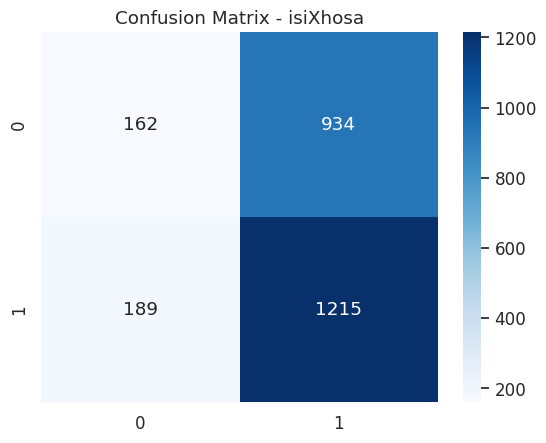

In [44]:
eval_results = trainer.evaluate()
print(" Evaluation:", eval_results)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds = trainer.predict(xhosa_tok)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - isiXhosa")
plt.show()


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       475
           1       0.90      0.94      0.92       924

    accuracy                           0.89      1399
   macro avg       0.88      0.87      0.87      1399
weighted avg       0.89      0.89      0.89      1399



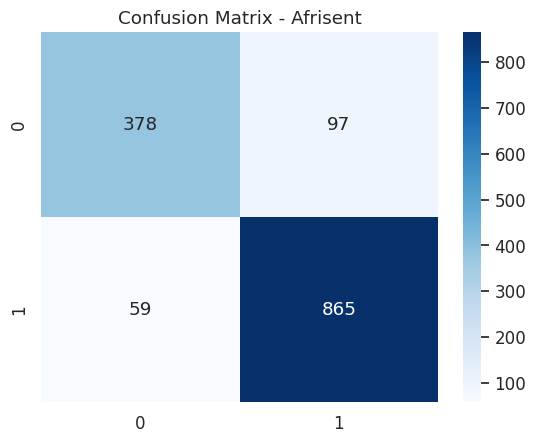

In [45]:
# eval_results = trainer.evaluate()
# print(" Training Evaluation:", eval_results)

preds_1 = trainer.predict(afrisenti_tok)
y_true1 = preds_1.label_ids
y_pred1 = np.argmax(preds_1.predictions, axis=-1)

print(classification_report(y_true1, y_pred1))

cm = confusion_matrix(y_true1, y_pred1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Afrisent")
plt.show()


#** Model explainability**

In [46]:
# Optional SHAP explainability (slow on large models)
import shap

sample_texts = [xhosa_dataset[i]["text"] for i in range(10)]

In [47]:
# Extract raw text from your Hugging Face dataset (first 10 samples)
sample_texts = [xhosa_dataset[i]['text'] for i in range(10)]

# Clean and ensure all entries are non-empty strings
sample_texts = [str(text) for text in sample_texts if isinstance(text, str) and text.strip() != '']

print(sample_texts)


['Cofa apha ukuze uthumele impendulo kaDaniela!', 'Nangee Samlang', 'Nika uxolo kwilizwe lam nakwizizwe zonke.', 'Iibhedi zasemini', 'okay..here goes nothing...thanks', 'Kodwa ekugqibeleni, wagqiba kweZakhar Salenko.', 'Joyous Celebration - Wena Wedwa Qha (Live)', 'AmaZulu afumene amanqaku amathathu apheleleyo.', 'eyam yeyam ayisebenzi i-wifi, idatha, umnxeba, emva kokuyifaka. ungandinceda?', 'Nantoni na eyenziwa ngumntwana kwintanga yesibini, kufuneka uhlale ekhusela.']


In [48]:
explainer = shap.Explainer(
    lambda x: model(**tokenizer(x, return_tensors="pt", padding=True, truncation=True).to(device)).logits,
    tokenizer
)

# shap_values = explainer(sample_texts)
# shap.plots.text(shap_values[0])



In [49]:
for i, text in enumerate(sample_texts):
    print(f"Index {i}: type={type(text)}, repr={repr(text)}")

Index 0: type=<class 'str'>, repr='Cofa apha ukuze uthumele impendulo kaDaniela!'
Index 1: type=<class 'str'>, repr='Nangee Samlang'
Index 2: type=<class 'str'>, repr='Nika uxolo kwilizwe lam nakwizizwe zonke.'
Index 3: type=<class 'str'>, repr='Iibhedi zasemini'
Index 4: type=<class 'str'>, repr='okay..here goes nothing...thanks'
Index 5: type=<class 'str'>, repr='Kodwa ekugqibeleni, wagqiba kweZakhar Salenko.'
Index 6: type=<class 'str'>, repr='Joyous Celebration - Wena Wedwa Qha (Live)'
Index 7: type=<class 'str'>, repr='AmaZulu afumene amanqaku amathathu apheleleyo.'
Index 8: type=<class 'str'>, repr='eyam yeyam ayisebenzi i-wifi, idatha, umnxeba, emva kokuyifaka. ungandinceda?'
Index 9: type=<class 'str'>, repr='Nantoni na eyenziwa ngumntwana kwintanga yesibini, kufuneka uhlale ekhusela.'


In [50]:
tokens = tokenizer(sample_texts, return_tensors="pt", padding=True, truncation=True)
print(tokens)


{'input_ids': tensor([[     0,   1311,   1021,     10,  14612,  65460,      6,  99424,  32128,
          48793,  12487,    365,    156, 217732,     11,     38,      2,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1],
        [     0,  66105,   7039,   3362,   3066,      2,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1],
        [     0, 145055,      6,   6077,   7537,  22951,    150,  39862,     21,
             39,   2593,  44239,     14,  39862, 118860,      5,      2,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1],
        [     0,     87, 137874,    428,  21630,   9222,      2,      1,      1,
  

In [51]:
import torch.nn.functional as F

def f(x):
    inputs = tokenizer(x, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    return probs.detach().cpu().numpy()


In [52]:
from transformers import pipeline

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)  # device=0 for GPU

explainer = shap.Explainer(pipe)
shap_values = explainer(sample_texts)
shap.plots.text(shap_values)


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [00:13<00:01,  4.73it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [00:20<00:06,  1.55s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [00:34<00:08,  4.15s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [00:45<00:06,  6.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [00:55<00:00,  7.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [01:05,  6.51s/it]


In [53]:
# Show token-level color visualization (works best for text)
shap.plots.text(shap_values[9])

# Force plot version (less visually intuitive for text, but possible)
shap.plots.force(
    explainer.expected_value,
    shap_values.values[0],
    matplotlib=True
)




NotImplementedError: matplotlib = True is not yet supported for force plots with multiple samples!

In [ ]:
# Classic pink/blue summary plot
# shap_values = explainer(sample_texts)

# shap.summary_plot(
#     shap_values.values,       # The SHAP contribution values
#     features=shap_values.data,  # The actual token strings
#     feature_names=tokenizer.get_vocab(),  # optional
#     plot_type="bar"
# )


# **Zero-shot: model trained only on Swahili (AfriSenti)**

In [1]:
# Zero-shot: model trained only on Swahili (AfriSenti)
zero_shot_result = trainer.evaluate(xhosa_tok)

# Few-shot: fine-tune on small isiXhosa subset
few_shot_subset = xhosa_tok.shuffle(seed=42).select(range(500))
trainer.train_dataset = few_shot_subset
trainer.train()
few_shot_result = trainer.evaluate(xhosa_tok)

print("Zero-shot F1:", zero_shot_result["eval_f1"])
print("Few-shot F1:", few_shot_result["eval_f1"])

# Save both results
comparison = pd.DataFrame([
    {"Setup": "Zero-shot", **zero_shot_result},
    {"Setup": "Few-shot", **few_shot_result}
])
comparison.to_csv(f"{PROJECT_DIR}/outputs/transfer_results.csv", index=False)


NameError: name 'trainer' is not defined